## Loading Packages

In [43]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import polars as pl
import pandas as pd
from IPython.display import display

from sklearn.metrics import root_mean_squared_error

## Loading Data

In [2]:
import libsql_experimental as libsql
import os

conn = libsql.connect(
    database=os.getenv("TURSO_DATABASE_URL"),
    auth_token=os.getenv("TURSO_AUTH_TOKEN")
)

try: 
    housing_db = pl.read_database(query="SELECT * FROM housing", connection=conn)
except Exception as e:
    print(f'Error: {e}')

# This finally block is always executed regardless of whether an exception is activated or not
finally:
    conn.close()    # Close connections

In [3]:
housing_db.head()

id,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
i64,i64,i64,i64,i64,i64,str,str,str,str,str,i64,str,str
1,13300000,7420,4,2,3,"""yes""","""no""","""no""","""no""","""yes""",2,"""yes""","""furnished"""
2,12250000,8960,4,4,4,"""yes""","""no""","""no""","""no""","""yes""",3,"""no""","""furnished"""
3,12250000,9960,3,2,2,"""yes""","""no""","""yes""","""no""","""no""",2,"""yes""","""semi-furnished"""
4,12215000,7500,4,2,2,"""yes""","""no""","""yes""","""no""","""yes""",3,"""yes""","""furnished"""
5,11410000,7420,4,1,2,"""yes""","""yes""","""yes""","""no""","""yes""",2,"""no""","""furnished"""


In [4]:
housing = housing_db.clone().select(pl.col("*").exclude("id")).to_pandas()
housing.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,yes,no,no,no,yes,2,yes,furnished
1,12250000,8960,4,4,4,yes,no,no,no,yes,3,no,furnished
2,12250000,9960,3,2,2,yes,no,yes,no,no,2,yes,semi-furnished
3,12215000,7500,4,2,2,yes,no,yes,no,yes,3,yes,furnished
4,11410000,7420,4,1,2,yes,yes,yes,no,yes,2,no,furnished


## Data Processing

In [5]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split

In [6]:
X = housing.iloc[:, 1:]
y = housing.iloc[:, 0]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=5, shuffle=True)

In [7]:
X_val = X_test.sample(frac=0.33, random_state=5)
X_test = X_test.drop(X_val.index)

y_val = y_test.loc[X_val.index.tolist()]
y_test = y_test.loc[X_test.index.tolist()]

In [8]:
y_train_df = y_train.to_frame()
y_test_df = y_test.to_frame()
y_val_df = y_val.to_frame()

In [9]:
# Building a pipeline to process numeric variables
numeric_transformer = Pipeline(
    steps = [
        # Step 1: Impute any missing data with the variable mean
        ("imputation_mean", SimpleImputer(strategy='mean')),
        
        # Step 2: Scale data within the variable
        ("scaler", StandardScaler())
    ]
)

# Building a pipeline to process categorical variables
categorical_transformer = Pipeline(
    steps = [
        # Step 1: Impute any missing data with the variable mode
        ("imputation_mode", SimpleImputer(strategy='most_frequent')),
        
        # Step 2: Encode the categorical data into numerical data
        ("encoder", OneHotEncoder(handle_unknown='ignore'))
    ]
)

# Segment feature variables by datatype
numeric_var = X.select_dtypes(include=['int64']).columns.tolist()
categorical_var = X.select_dtypes(include=['object', 'string']).columns.tolist()

# Combine pipelines into one processor for feature variable and one processor for the target variable
feature_processor = ColumnTransformer([
    ("int", numeric_transformer, numeric_var),
    ("str", categorical_transformer, categorical_var)
])

target_processor = ColumnTransformer([
    ("int", numeric_transformer, ['price'])
])

In [10]:
# Preprocessed data
y_train_processed = target_processor.fit_transform(y_train_df)
y_test_processed = target_processor.transform(y_test_df)
y_val_processed = target_processor.transform(y_val_df)

X_train_processed = feature_processor.fit_transform(X_train)
X_test_processed = feature_processor.transform(X_test)
X_val_processed = feature_processor.transform(X_val)

## Linear Regression

In [11]:
from sklearn.linear_model import LinearRegression

linear = LinearRegression(fit_intercept=False)
linear.fit(X_train_processed, y_train_processed)

print(f"Coefficients (scaled / encoded) : {linear.coef_[0]}")

Coefficients (scaled / encoded) : [ 0.26122504  0.03296405  0.27057337  0.18807512  0.14970018 -0.04367193
  0.14913522 -0.00647608  0.11193938 -0.04704412  0.15250742 -0.17328733
  0.27875063 -0.18383539  0.28929869 -0.11767182  0.22313512  0.10184039
  0.0919908  -0.08836789]


### Coefficients

In [12]:
scaler = feature_processor.named_transformers_['int'].named_steps['scaler']
scaled_coeffs_count = scaler.scale_.shape[0]
scaled_coeffs = linear.coef_[0][ : scaled_coeffs_count].reshape(1, -1)
inversed_scaled_coeffs = scaler.inverse_transform(scaled_coeffs).tolist()[0]
numeric_coeffs = [round(x, 3) if i == 0 else round(x) for i, x in enumerate(inversed_scaled_coeffs)]

encoder = feature_processor.named_transformers_['str'].named_steps['encoder']
encoded_coeffs = linear.coef_[0][scaled_coeffs_count : ].reshape(1, -1)
categorical_coeffs = encoder.inverse_transform(encoded_coeffs).tolist()[0]

coefficients = numeric_coeffs + categorical_coeffs

pl.Config.set_tbl_rows(-1)
pl.DataFrame({'Variable' : X_train.columns, 'Coefficient' : coefficients}, strict=False)

Variable,Coefficient
str,str
"""area""","""5732.283"""
"""bedrooms""","""3"""
"""bathrooms""","""1"""
"""stories""","""2"""
"""mainroad""","""1"""
"""guestroom""","""yes"""
"""basement""","""yes"""
"""hotwaterheating""","""yes"""
"""airconditioning""","""yes"""


### Evaluation

In [13]:
linear_predictions = linear.predict(X_test_processed).flatten()

In [44]:
linear_r2_score = (linear.score(X_test_processed, y_test_processed) * 100)
print(f"R-squared score: {linear_r2_score:.2f}%")

linear_rmse = root_mean_squared_error(y_test_processed, linear_predictions)
print(f"RMSE score: {linear_rmse:.3f}")

R-squared score: 59.53%
RMSE score: 0.486


### Visualisation

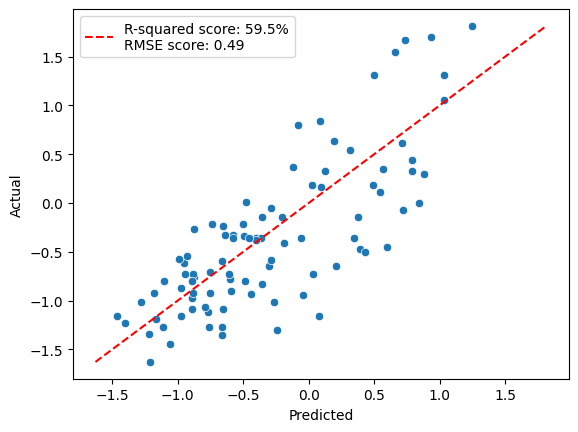

In [45]:
max_val = max(y_test_processed.max(), linear_predictions.max())
min_val = min(y_test_processed.min(), linear_predictions.min())

fig, ax = plt.subplots(1, 1)

sns.scatterplot(x=linear_predictions, y=y_test_processed.flatten(), ax=ax).set(xlabel='Predicted', ylabel='Actual')
plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', linewidth=1.5, label=f"R-squared score: {linear_r2_score:.1f}%\nRMSE score: {linear_rmse:.2f}")
plt.legend(loc='best')

## Lasso Regression

In [16]:
from sklearn.linear_model import Lasso

lasso = Lasso(alpha=0.0001, fit_intercept=False, random_state=5)
lasso.fit(X_train_processed, y_train_processed)

print(f"Coefficients (scaled / encoded) : {lasso.coef_}")

Coefficients (scaled / encoded) : [ 0.26129434  0.03293897  0.27061575  0.18809013  0.14971818 -0.11414802
  0.07801098 -0.02286947  0.09524122 -0.07133742  0.12801646 -0.01983025
  0.42965539 -0.16567331  0.30701698 -0.08511649  0.25534948  0.00967818
  0.         -0.18014129]


In [17]:
scaler = feature_processor.named_transformers_['int'].named_steps['scaler']
scaled_coeffs_count = scaler.scale_.shape[0]
scaled_coeffs = lasso.coef_[ : scaled_coeffs_count].reshape(1, -1)
inversed_scaled_coeffs = scaler.inverse_transform(scaled_coeffs).tolist()[0]
numeric_coeffs = [round(x, 3) if i == 0 else round(x) for i, x in enumerate(inversed_scaled_coeffs)]

encoder = feature_processor.named_transformers_['str'].named_steps['encoder']
encoded_coeffs = lasso.coef_[scaled_coeffs_count : ].reshape(1, -1)
categorical_coeffs = encoder.inverse_transform(encoded_coeffs).tolist()[0]

coefficients = numeric_coeffs + categorical_coeffs

pl.Config.set_tbl_rows(-1)
pl.DataFrame({'Variable' : X_train.columns, 'Coefficient' : coefficients}, strict=False)

Variable,Coefficient
str,str
"""area""","""5732.429"""
"""bedrooms""","""3"""
"""bathrooms""","""1"""
"""stories""","""2"""
"""mainroad""","""1"""
"""guestroom""","""yes"""
"""basement""","""yes"""
"""hotwaterheating""","""yes"""
"""airconditioning""","""yes"""


### Evaluation

In [18]:
lasso_predictions = lasso.predict(X_test_processed).flatten()

In [46]:
lasso_r2_score = (lasso.score(X_test_processed, y_test_processed) * 100)
print(f"R-squared score: {lasso_r2_score:.2f}%")


lasso_rmse = root_mean_squared_error(y_test_processed, lasso_predictions)
print(f"RMSE score: {lasso_rmse:.3f}")

R-squared score: 59.53%
RMSE score: 0.486


### Visualisation

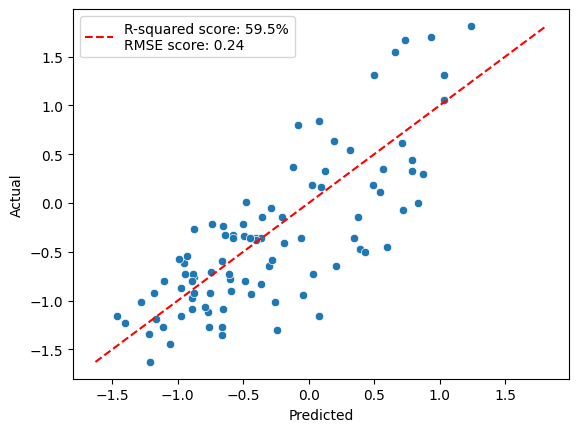

In [41]:
max_val = max(y_test_processed.max(), lasso_predictions.max())
min_val = min(y_test_processed.min(), lasso_predictions.min())

fig, ax = plt.subplots(1, 1)

# Comparing predicted and actual datapoints
sns.scatterplot(x=lasso_predictions, y=y_test_processed.flatten(), ax=ax).set(xlabel='Predicted', ylabel='Actual')

# Regression line
plt.plot(
    [min_val, max_val], [min_val, max_val], 
    color='red', linestyle='--', linewidth=1.5, 
    label=f'R-squared score: {lasso_r2_score:.1f}%\nRMSE score: {lasso_rmse:.2f}'
)

# R-squared score
plt.legend(loc='best')

## Neural Network

In [21]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

device = 'cuda' if torch.cuda.is_available() else 'cpu'  # 'mps' is for Apple Silicon while 'cuda' is for Nvidia 

print(device)

cuda


### Loading Tensor data

In [22]:
X_train_tensor = torch.tensor(X_train_processed, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_processed, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val_processed, dtype=torch.float32)

y_train_tensor = torch.tensor(y_train_processed, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test_processed, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val_processed, dtype=torch.float32)

### Designing Model Architecture

In [23]:
class LinearModel(nn.Module):
    def __init__(self, input_size, output_size):
        super().__init__()  # Inherit constructor from parent class (nn.Module) to initialise the parent class
        
        # Build sequential layer
        self.sequential_layer = nn.Sequential(
            nn.Dropout(p=0.25),         # 25% of the input features will be randomly set to zero
            nn.Linear(input_size, 128), # Linear layer 1
            nn.LeakyReLU(),             # Leaky rectified linear unit (activation function)
            nn.Dropout(p=0.25),
            nn.Linear(128, 64),         # Linear layer 2
            nn.LeakyReLU(),
            nn.Dropout(p=0.25),
            nn.Linear(64, 32),          # Linear layer 3
            nn.LeakyReLU(),                  
            nn.Linear(32, output_size)
        )

    # The forward pass simply calls the sequential layer
    def forward(self, x):
        return self.sequential_layer(x)

In [24]:
X_train_tensor = X_train_tensor.to(device)
y_train_tensor = y_train_tensor.to(device)

X_test_tensor = X_test_tensor.to(device)
y_test_tensor = y_test_tensor.to(device)

X_val_tensor = X_val_tensor.to(device)
y_val_tensor = y_val_tensor.to(device)

### Hyperparameter Tuning

Stochastic Gradient Descent : $\text{Parameter} = \text{Parameter} - (\text{Learning rate} \times \text{Gradient})$

In [25]:
linear_model = LinearModel(input_size = X_train_processed.shape[1], output_size=1)
linear_model.to(device)
mse_loss_criterion = nn.MSELoss(reduction="mean")


from sklearn.model_selection import ParameterGrid

# Define hyperparameter grid
param_grid = {
    'lr': [0.01, 0.001],
    'weight_decay': [0.001, 0.0001],
    'epochs' : [1000, 5000, 10000]
}


# Perform grid search to find the best parameters
best_parameters = None
best_loss = float('inf')

# Go through a grid with all possible combinations of the specified hyperparameters
for params in ParameterGrid(param_grid):
    print(f"Testing parameters: {params}")

    for epoch in range(params['epochs']):
    
        adam_optimiser = optim.Adam(linear_model.parameters(), lr=params['lr'], weight_decay=params['weight_decay'])
        
        linear_model.train()
        
        # Forward pass
        X_train_pred = linear_model(X_train_tensor)
        
        # Calculate loss
        train_mse_loss = mse_loss_criterion(X_train_pred, y_train_tensor)
        
        # Backward pass and optimisation
        adam_optimiser.zero_grad()
        
        train_mse_loss.backward()
        
        adam_optimiser.step()
        
        # Validation
        linear_model.eval()
        
        X_val_pred = linear_model(X_val_tensor)
        
        val_mse_loss = mse_loss_criterion(X_val_pred, y_val_tensor)

    # Update best parameters if current validation loss is lower
    if val_mse_loss < best_loss:
        best_loss = val_mse_loss.item()
        best_params = params

Testing parameters: {'epochs': 1000, 'lr': 0.01, 'weight_decay': 0.001}
Testing parameters: {'epochs': 1000, 'lr': 0.01, 'weight_decay': 0.0001}
Testing parameters: {'epochs': 1000, 'lr': 0.001, 'weight_decay': 0.001}
Testing parameters: {'epochs': 1000, 'lr': 0.001, 'weight_decay': 0.0001}
Testing parameters: {'epochs': 5000, 'lr': 0.01, 'weight_decay': 0.001}
Testing parameters: {'epochs': 5000, 'lr': 0.01, 'weight_decay': 0.0001}
Testing parameters: {'epochs': 5000, 'lr': 0.001, 'weight_decay': 0.001}
Testing parameters: {'epochs': 5000, 'lr': 0.001, 'weight_decay': 0.0001}
Testing parameters: {'epochs': 10000, 'lr': 0.01, 'weight_decay': 0.001}
Testing parameters: {'epochs': 10000, 'lr': 0.01, 'weight_decay': 0.0001}
Testing parameters: {'epochs': 10000, 'lr': 0.001, 'weight_decay': 0.001}
Testing parameters: {'epochs': 10000, 'lr': 0.001, 'weight_decay': 0.0001}


In [26]:
print(f"The best parameters: {best_params} with the lowest loss of {best_loss:.3f}")

The best parameters: {'epochs': 1000, 'lr': 0.001, 'weight_decay': 0.0001} with the lowest loss of 0.303


### Training

In [27]:
best_linear_model = LinearModel(input_size = X_train_processed.shape[1], output_size=1)
best_linear_model.to(device)

best_adam_optimiser = optim.Adam(best_linear_model.parameters(), lr=best_params['lr'], weight_decay=best_params['weight_decay'])
mse_criterion = nn.MSELoss(reduction='mean')

In [28]:
training_loss = []
visualising_training_loss = []

validation_loss = []
visualising_validation_loss = []

x_epochs = 100
num_epochs = best_params['epochs']

for epoch in range(num_epochs):
    
    best_linear_model.train()
    
    # Forward pass
    X_train_pred = best_linear_model(X_train_tensor)
    
    # Calculate loss
    train_mse_loss = mse_loss_criterion(X_train_pred, y_train_tensor)
    training_loss.append(train_mse_loss.item())
    
    # Backward pass and optimisation
    best_adam_optimiser.zero_grad()
    
    train_mse_loss.backward()
    
    best_adam_optimiser.step()
    
    # Validation
    linear_model.eval()
    
    X_val_pred = linear_model(X_val_tensor)
    
    val_mse_loss = mse_loss_criterion(X_val_pred, y_val_tensor)
    validation_loss.append(val_mse_loss.item())
    
    
    if epoch == 0:
        print(f"Epoch {epoch} of {num_epochs} | Training Loss: {train_mse_loss.item():.3f} | Validation Loss :{val_mse_loss.item():.3f}")
        # visualising_training_loss.append(train_mse_loss.item())
    
    if (epoch + 1) % x_epochs == 0:
        print(f"Epoch {epoch + 1} of {num_epochs} | Average training loss: {np.mean(training_loss):.3f} | Average validation loss: {np.mean(validation_loss):.3f}")
    
    if (epoch + 1) % x_epochs == 0: 
        visualising_training_loss.append(np.mean(training_loss))
        visualising_validation_loss.append(np.mean(validation_loss))

Epoch 0 of 1000 | Training Loss: 1.026 | Validation Loss :0.309
Epoch 100 of 1000 | Average training loss: 0.511 | Average validation loss: 0.309
Epoch 200 of 1000 | Average training loss: 0.444 | Average validation loss: 0.309
Epoch 300 of 1000 | Average training loss: 0.412 | Average validation loss: 0.309
Epoch 400 of 1000 | Average training loss: 0.392 | Average validation loss: 0.309
Epoch 500 of 1000 | Average training loss: 0.378 | Average validation loss: 0.309
Epoch 600 of 1000 | Average training loss: 0.366 | Average validation loss: 0.309
Epoch 700 of 1000 | Average training loss: 0.356 | Average validation loss: 0.309
Epoch 800 of 1000 | Average training loss: 0.348 | Average validation loss: 0.309
Epoch 900 of 1000 | Average training loss: 0.341 | Average validation loss: 0.309
Epoch 1000 of 1000 | Average training loss: 0.334 | Average validation loss: 0.309


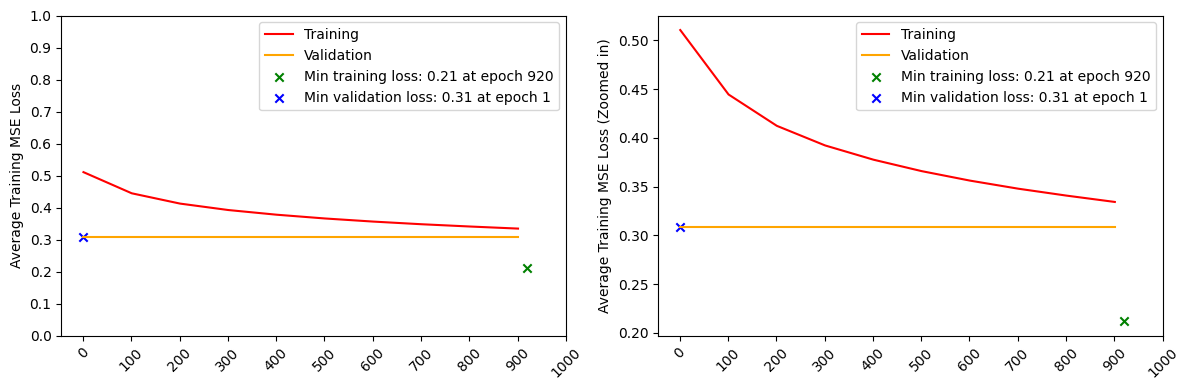

In [35]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

for ax in (ax1, ax2):
    
    ax.plot(
        np.arange(1, num_epochs+1, x_epochs).tolist(),
        visualising_training_loss,
        color='red',
        label='Training'
    )
    
    ax.plot(
        np.arange(1, num_epochs+1, x_epochs).tolist(),
        visualising_validation_loss,
        color='orange',
        label='Validation'
    )

    ax.scatter(
            training_loss.index(min(training_loss)) + 1,
            min(training_loss),
            label=f'Min training loss: {min(training_loss):.2f} at epoch {training_loss.index(min(training_loss)) + 1}',
            color='green',
            marker='x'
        )
    
    ax.scatter(
            validation_loss.index(min(validation_loss)) + 1,
            min(validation_loss),
            label=f'Min validation loss: {min(validation_loss):.2f} at epoch {validation_loss.index(min(validation_loss)) + 1}',
            color='blue',
            marker='x'
        )

    ax.set_xticks(np.arange(0, num_epochs+1, 100))
    ax.tick_params(axis='x', labelrotation=45)
    
    if ax == ax1:
        ax.set_ylim(0, 1)
        ax.set_yticks(np.arange(0, 1.1, 0.1))
        ax.set_ylabel("Average Training MSE Loss")
    else:
        ax.set_ylabel("Average Training MSE Loss (Zoomed in)")

    ax.legend(loc='best')

plt.tight_layout()

### Evaluation

In [30]:
testing_loss = []

linear_model.eval()

with torch.no_grad():
    nn_pred = linear_model(X_test_tensor)
    
    for i in range(X_test_tensor.shape[0]):
        mse_loss = mse_loss_criterion(nn_pred[i], y_test_tensor[i])
        testing_loss.append(mse_loss.item())

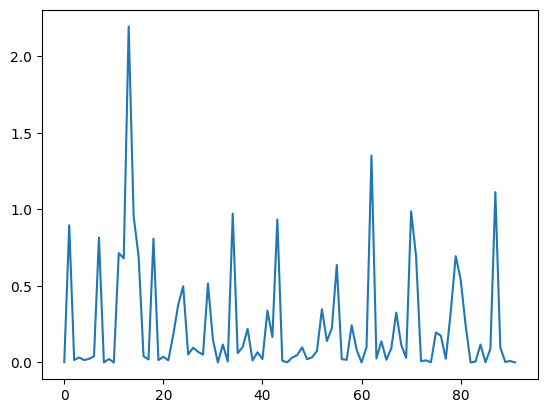

In [31]:
fig, ax = plt.subplots()

plt.plot(
    np.arange(0, len(testing_loss)).tolist(),
    testing_loss
)

In [47]:
from sklearn.metrics import r2_score

nn_pred_np = nn_pred.detach().cpu().numpy().flatten()

nn_r2_score = r2_score(y_test_processed, nn_pred_np)
print(f"R-squared score: {nn_r2_score:.3f}")

nn_rmse = root_mean_squared_error(y_test_processed, nn_pred_np)
print(f"RMSE score: {nn_rmse:.3f}")

R-squared score: 0.579
RMSE score: 0.496


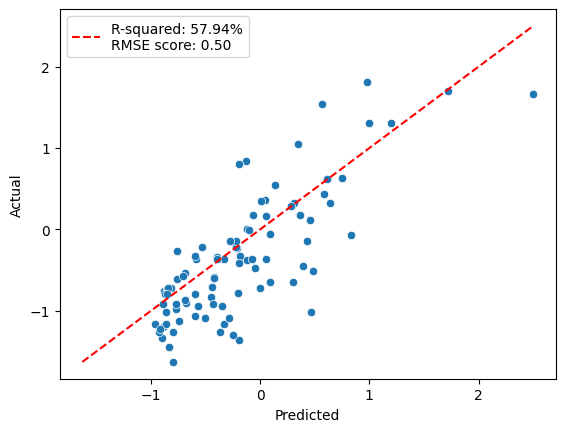

In [48]:
fig, ax = plt.subplots(1, 1)

# Comparing predicted and actual datapoints
sns.scatterplot(x=nn_pred_np, y=y_test_processed.flatten(), ax=ax).set(xlabel='Predicted', ylabel='Actual')

# Regression line
max_val = max(y_test_processed.max(), nn_pred_np.max())
min_val = min(y_test_processed.min(), nn_pred_np.min())

plt.plot(
    [min_val, max_val], [min_val, max_val], 
    color='red', linestyle='--', linewidth=1.5, 
    label=f'R-squared: {(nn_r2_score * 100):.2f}%\nRMSE score: {nn_rmse:.2f}'
)

plt.legend(loc='best')